### Домашнее задание (Оценка качества моделей)

Дана статистика пользователей adult.csv.

Получите значения AUC для различных моделей и их параметров.

Решением будет ссылка на гитхаб с ноутбуком.

In [131]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from pylab import plot, show, hist, rcParams
rcParams['figure.figsize'] = 8, 5

import seaborn as sns
sns.set(style='dark')
sns.set(style= 'darkgrid', color_codes=True)

%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


from jupyterthemes import jtplot
jtplot.style(figsize=(8.0, 6.0))

import warnings
warnings.simplefilter('ignore')

### Решение

для решения я буду использовать чась `(подготовка данных)` уже ранее выполненого ДЗ `"Алгоритмы классификации: линейные методы, логистическая регрессия и SVM"` а для оценки качества добавлю несколько других алгоритмов 

#### Часть I (подготовка данных) весь код из предыдущего ДЗ

In [8]:
#загрузим данные
data = pd.read_csv('adult.csv')

In [9]:
#заполним пропуски
data.loc[data.workclass == '?', 'workclass'] = 'Private'
data.loc[data.occupation == '?', 'occupation'] = 'Missed'
data.loc[data['native-country'] == '?', 'native-country'] = 'United-States'

In [11]:
selected_columns = data[['age', 'hours-per-week', 'workclass', 'education', \
                                                                    'occupation', 'marital-status', 'relationship']]

In [12]:
X = pd.get_dummies(selected_columns, columns = \
                               ['workclass', 'education', 'occupation', 'marital-status', 'relationship'])

In [13]:
#создадим список со значениями нашего таргета
target = data['income']

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [15]:
#зафитим наш таргет
le.fit(target)

LabelEncoder()

In [16]:
y = pd.Series(le.transform(data['income']))

### Разделим наш набор данных на трейн и тест

In [21]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3)

### Часть II (Оценка качества моделей) 

для оценки качества я буду использовать разные метрики качества (для этого буду использовать библиотеку sklearn.metrics), также я построою confusion_matrix
для эксперемента я буду использовать следующие алгоритмы:
- Логистическая регрессия (LogisticRegression)
- Наивный Байес (GaussianNB)
- K-ближайших соседей (KNeighborsClassifier)
- Деревья решений (DecisionTreeClassifier)

##### - Эксперемент 1 ((LogisticRegression)

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
logreg = LogisticRegression()

In [24]:
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Посмотрим accuracy

In [31]:
print('Результата на трейне : {:.4f}'.format(logreg.score(X_train, Y_train)))
print('Результата на тесте : {:.4f}'.format(logreg.score(X_test, Y_test)))

Результата на трейне : 0.8373
Результата на тесте : 0.8325


- Посмотрим как наша модель предсказывает результат (класс обьекта)

In [38]:
y_pred = logreg.predict(X_test)
print('Accuracy на тесте: {:.4f}'.format(logreg.score(X_test, Y_test)))

Accuracy на тесте: 0.8325


#### Посмотрим на метрики качества precision, recall, f1-score

In [39]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

             precision    recall  f1-score   support

          0       0.86      0.93      0.89     11118
          1       0.70      0.54      0.61      3535

avg / total       0.82      0.83      0.82     14653



In [200]:
#построим confusion_matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, y_pred)
print(confusion_matrix)

[[10288   830]
 [ 1625  1910]]


- Посмотрим как наша модель предсказывает вероятность отнесения к определенному классу

In [108]:
y_pred_proba = logreg.predict_proba(X_test)
y_pred_proba_t = logreg.predict_proba(X_train)

#### Построим график precision recall

In [58]:
from sklearn.metrics import precision_recall_curve

- Построим график precision recall на train

In [109]:
pr_t, re_t, thres_t = precision_recall_curve(Y_train, y_pred_proba_t[:, 1] )

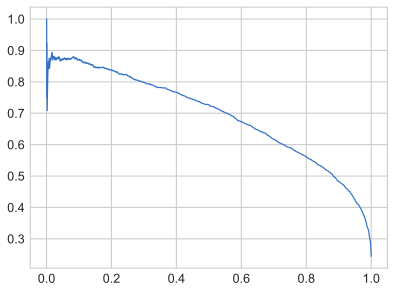

In [132]:
plt.plot( re_t, pr_t, 'b')

- Построим график precision recall на test

In [114]:
pr, re, thres = precision_recall_curve(Y_test, y_pred_proba[:, 1] )

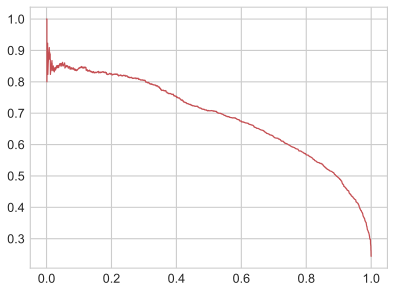

In [133]:
plt.plot( re, pr, 'r')

#### Построим ROC-кривую (Receiver Operating Characteristic)

In [73]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [121]:
def show_auc(y, y_pred, plot_label='', prin=True):   
    """
    функция принимает на вход результаты предсказных значений
    и возвращает визуализацию площади под кривой AUC
    """
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC-AUC')
        plt.legend(loc="lower right")
    return auc_val

Train:
ROC AUC: 0.8863
Test:
ROC AUC: 0.8846


0.8846185944629464

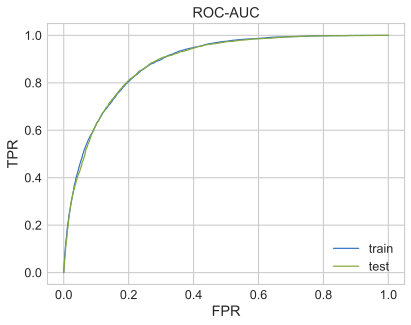

In [134]:
y_pred_test = logreg.predict_proba(X_test)[:, 1]
y_pred_train = logreg.predict_proba(X_train)[:, 1]

print('Train:')
show_auc(Y_train, y_pred_train, 'train')
         
print('Test:')
show_auc(Y_test, y_pred_test, 'test')

#### Теперь подергаем параметры модели (сделаем несколько новых моделей c L1 и L2  регуляризацией)

In [188]:
logregL1 = LogisticRegression(penalty = 'l1', C = 0.1 ).fit( X_train, Y_train )
predictions1 = logregL1.predict_proba( X_test )

In [189]:
logregL2 = LogisticRegression(penalty = 'l2', C = 0.001 ).fit( X_train, Y_train )
predictions2 = logregL2.predict_proba( X_test )

In [190]:
fpr, tpr, thres = roc_curve( Y_test, predictions1[:, 1] )
fpr2, tpr2, thres2 = roc_curve( Y_test, predictions2[:, 1] )

Test:
ROC AUC: 0.8841
Test:
ROC AUC: 0.8471


0.8471383357594104

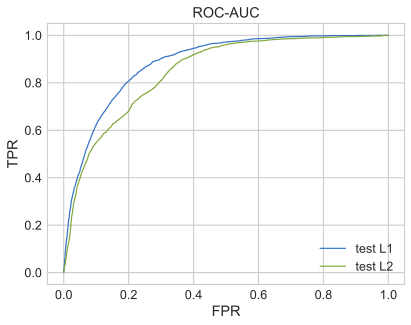

In [219]:
predictions1 = logregL1.predict_proba( X_test )[:, 1]
predictions2 = logregL2.predict_proba( X_test )[:, 1]

print('Test:')
show_auc(Y_test, predictions1, 'test L1')
         
print('Test:')
show_auc(Y_test, predictions2, 'test L2')

##### - Эксперемент 2 (GaussianNB)

In [214]:
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(X_train,  Y_train)
print(GNB)

expected_t = Y_train
predicted_t = GNB.predict(X_train)

expected_test = Y_test
predicted_test = GNB.predict(X_test)

print('Train ------------------------------------------------')
print(metrics.classification_report(expected_t, predicted_t))
print(metrics.confusion_matrix(expected_t, predicted_t))

print('Test -------------------------------------------------')
print(metrics.classification_report(expected_test, predicted_test))
print(metrics.confusion_matrix(expected_test, predicted_test))

GaussianNB(priors=None)
Train ------------------------------------------------
             precision    recall  f1-score   support

          0       0.95      0.60      0.73     26037
          1       0.41      0.90      0.57      8152

avg / total       0.82      0.67      0.69     34189

[[15530 10507]
 [  805  7347]]
Test -------------------------------------------------
             precision    recall  f1-score   support

          0       0.95      0.60      0.74     11118
          1       0.42      0.90      0.57      3535

avg / total       0.82      0.67      0.70     14653

[[6710 4408]
 [ 363 3172]]


Train:
ROC AUC: 0.8514
Test:
ROC AUC: 0.8474


0.8474422760293145

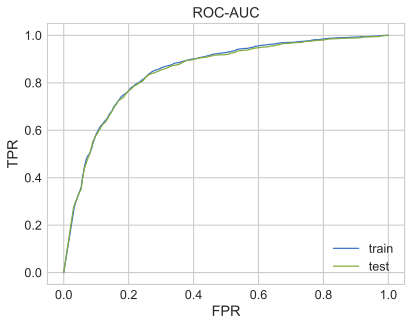

In [221]:
predictionsGNB = GNB.predict_proba( X_test )[:, 1]
predictionsGNB_t = GNB.predict_proba( X_train )[:, 1]


print('Train:')
show_auc(Y_train, predictionsGNB_t,'train')

print('Test:')
show_auc(Y_test, predictionsGNB, 'test')
    

##### - Эксперемент 3 (KNeighborsClassifier)

In [215]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

kNN = KNeighborsClassifier()
kNN.fit(X_train, Y_train)
print(kNN)

expected_tr = Y_train
predicted_tr = kNN.predict(X_train)

expected_ts = Y_test
predicted_ts = kNN.predict(X_test)

print('Train ------------------------------------------------')
print(metrics.classification_report(expected_tr, predicted_tr))
print(metrics.confusion_matrix(expected_tr, predicted_tr))

print('Test -------------------------------------------------')
print(metrics.classification_report(expected_ts, predicted_ts))
print(metrics.confusion_matrix(expected_ts, predicted_ts))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Train ------------------------------------------------
             precision    recall  f1-score   support

          0       0.90      0.92      0.91     26037
          1       0.74      0.68      0.71      8152

avg / total       0.86      0.87      0.86     34189

[[24064  1973]
 [ 2639  5513]]
Test -------------------------------------------------
             precision    recall  f1-score   support

          0       0.86      0.89      0.87     11118
          1       0.61      0.55      0.58      3535

avg / total       0.80      0.81      0.80     14653

[[9877 1241]
 [1607 1928]]


Train:
ROC AUC: 0.9225
Test:
ROC AUC: 0.8212


0.8211574410852541

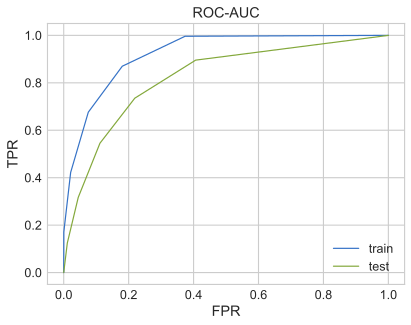

In [222]:
predictionskNN = kNN.predict_proba( X_test )[:, 1]
predictionskNN_t = kNN.predict_proba( X_train )[:, 1]


print('Train:')
show_auc(Y_train, predictionskNN_t,'train')

print('Test:')
show_auc(Y_test, predictionskNN, 'test')

##### - Эксперемент 4 (DecisionTreeClassifier)

In [217]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier()
DTC.fit(X_train, Y_train)
print(DTC)

exp = Y_train
pred = DTC.predict(X_train)

exp_ts = Y_test
pred_ts = DTC.predict(X_test)

print('Train ------------------------------------------------')
print(metrics.classification_report(exp, pred))
print(metrics.confusion_matrix(exp, pred))

print('Test -------------------------------------------------')
print(metrics.classification_report(exp_ts, pred_ts))
print(metrics.confusion_matrix(exp_ts, pred_ts))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Train ------------------------------------------------
             precision    recall  f1-score   support

          0       0.96      0.99      0.97     26037
          1       0.96      0.86      0.91      8152

avg / total       0.96      0.96      0.96     34189

[[25732   305]
 [ 1154  6998]]
Test -------------------------------------------------
             precision    recall  f1-score   support

          0       0.85      0.88      0.86     11118
          1       0.57      0.51      0.53      3535

avg / total       0.78      0.79      0.78     14653

[[9752 1366]
 [1748 1787]]


Train:
ROC AUC: 0.9943
Test:
ROC AUC: 0.7274


0.7273500952747345

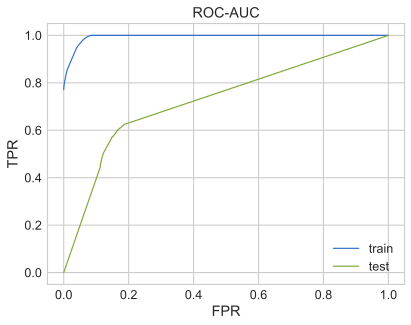

In [223]:
predictionsDTC = DTC.predict_proba( X_test )[:, 1]
predictionsDTC_t = DTC.predict_proba( X_train )[:, 1]

print('Train:')
show_auc(Y_train, predictionsDTC_t, 'train')
         
print('Test:')
show_auc(Y_test, predictionsDTC, 'test')